# Quickstart

This notebook shows how to train and validate a model with ScAPE and how to do predictions for cell/drug combinations

In [1]:
# Disable all warnings
import scape
import pandas as pd
import matplotlib.pyplot as plt

scape.__version__

'0.1.0'

In [2]:
df_de = scape.io.load_slogpvals("_data/de_train.parquet")
df_lfc = scape.io.load_lfc("_data/lfc_train.parquet")

# Make sure rows/columns are in the same order
df_lfc = df_lfc.loc[df_de.index, df_de.columns]
df_de.shape, df_lfc.shape

((614, 18211), (614, 18211))

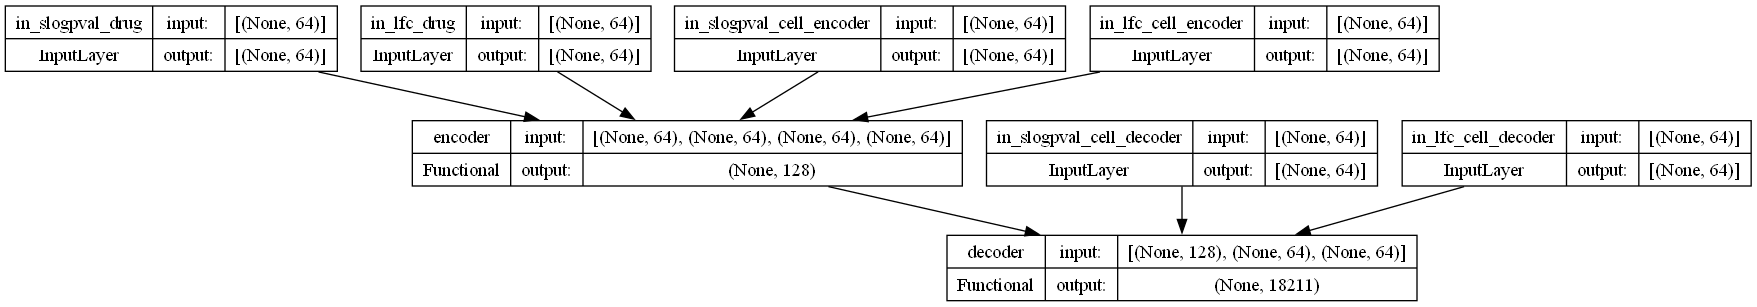

In [3]:
# We select only a subset of the genes for the model (top most variant genes)
n_genes = 64
top_genes = scape.util.select_top_variable([df_de], k=n_genes)

# Data sources point to the dataframes with the data from which the features are extracted
data_sources = {
    'slogpval': df_de,
    'lfc_pseudo': df_lfc
}

# Define the way in which the features are extracted from the data sources
feature_extraction = {
    'slogpval_drug': {
        'source': 'slogpval',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'lfc_drug': {
        'source': 'lfc_pseudo',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'slogpval_cell': {
        'source': 'slogpval',
        'groupby': 'cell_type',
        'function': 'median'
    },
    'lfc_cell': {
        'source': 'lfc_pseudo',
        'groupby': 'cell_type',
        'function': 'median'
    }
}

# Names of the input layers -> feature extraction method
input_mapping = {
    'in_slogpval_drug': 'slogpval_drug',
    'in_lfc_drug': 'lfc_drug',
    'in_slogpval_cell_encoder': 'slogpval_cell',
    'in_lfc_cell_encoder': 'lfc_cell',
    'in_slogpval_cell_decoder': 'slogpval_cell',
    'in_lfc_cell_decoder': 'lfc_cell',
}

# Configuration for the NN architecture
config = {
    "inputs": {
        "in_slogpval_drug"          : [n_genes, 256, 128],
        "in_lfc_drug"               : [n_genes, 256, 128],
    },
    "conditional_encoder_input_structure": {
        "in_slogpval_cell_encoder"  : [n_genes, 32],
        "in_lfc_cell_encoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_structure": {
        "in_slogpval_cell_decoder"  : [n_genes, 32],
        "in_lfc_cell_decoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_hidden_sizes": [32],
    "encoder_hidden_layer_sizes": [128, 128],
    "decoder_hidden_layer_sizes": [128, 512],
    "outputs": {
        "logpval": (df_de.shape[1], "linear"), 
    },
    # Layer config
    "noise": 0.01,
    "dropout": 0.05,
    "l1": 0,
    "l2": 0
}

model_setup = {
    "data_sources": data_sources,
    "feature_extraction": feature_extraction,
    "input_mapping": input_mapping,
    "output_genes": df_de.columns,
    "config": config
}

# Create model
scm = scape.SCAPE(model_setup)
scape.util.plot(scm.model, show_shapes=True)

In [4]:
scm.model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_slogpval_drug (InputLay  [(None, 64)]                 0         []                            
 er)                                                                                              
                                                                                                  
 in_lfc_drug (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 in_slogpval_cell_encoder (  [(None, 64)]                 0         []                            
 InputLayer)                                                                                      
                                                                                        

In [5]:
result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=300,
    baselines=["zero", "slogpval_drug"]
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']

Epoch    1: val_loss None -> 1.4200, train loss: 1.3089 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0051, 0.51%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7942, -25.92%
Epoch    2: val_loss 1.4200 -> 1.3870, train loss: 1.2842 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0290, 2.82%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8131, -22.99%
Epoch    3: val_loss 1.3870 -> 1.3483, train loss: 1.2568 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0586, 5.53%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8364, -19.55%
Epoch    9: val_loss 1.3483 -> 1.3391, tra

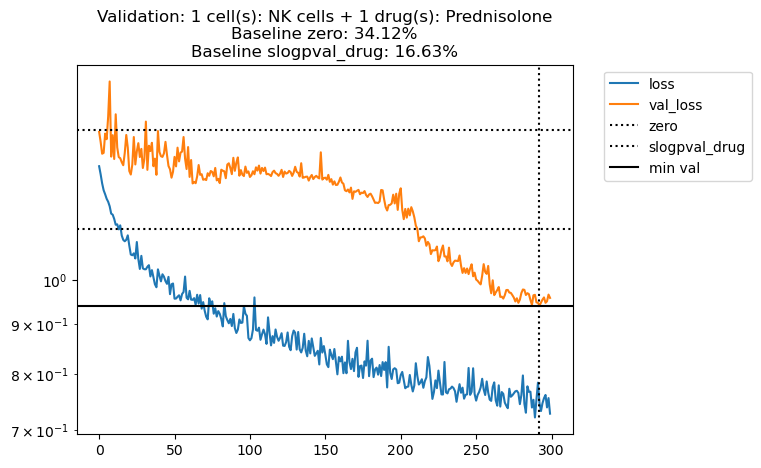

In [6]:
scape.util.plot_result(result, legend=True)

## Inference

In [7]:
# Predict using a given dataframe index
scm.predict(df_de)

20/20 [==============================] - 1s 12ms/step


,,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,sm_name,,,,,,,,,,,,,,,,,,,,,
NK cells,Clotrimazole,0.226597,0.232163,-0.162873,0.104159,0.233033,0.345349,0.107271,0.128381,-0.079176,0.211954,...,-0.090399,-0.148727,0.057265,0.168272,0.034693,0.095248,0.189461,0.047228,0.140729,0.115332
T cells CD4+,Clotrimazole,-0.014405,-0.044240,0.075286,-0.120665,0.054343,0.181366,-0.096792,0.130696,0.041673,0.200096,...,-0.170318,0.129960,0.032707,-0.027299,0.359101,-0.000355,0.235662,0.054407,0.291626,-0.040581
T cells CD8+,Clotrimazole,-0.152540,-0.470452,-0.327919,-0.104184,-0.121436,-0.443137,-0.147808,-0.271768,-0.373306,0.240658,...,0.033618,-0.469295,-0.444716,-0.522849,0.014100,-0.350525,0.014720,-0.202243,-0.043961,-0.185177
T regulatory cells,Clotrimazole,0.427216,0.319426,0.535728,0.757009,0.760641,0.693924,-0.057033,0.379983,-0.148994,0.180620,...,-0.003079,0.395791,0.113107,0.278417,0.549343,0.544681,0.437050,0.265641,-0.102731,-0.007233
NK cells,Mometasone Furoate,1.187296,0.189980,-0.297642,-0.082892,0.710227,1.952094,0.348308,0.963889,-0.269080,1.654359,...,-0.066286,-0.429258,0.393293,0.044852,0.370839,0.641327,0.178442,0.490419,-1.591568,0.395279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T regulatory cells,Atorvastatin,0.033422,-0.298380,-0.340061,-0.469489,-0.355412,-0.267874,-0.048356,-0.661239,-0.217262,-0.037620,...,-0.341472,-0.465568,-0.366644,-0.575812,-0.351197,-0.046234,-0.315636,-0.139549,-0.091955,-0.386184
NK cells,Riociguat,0.077335,0.155446,-0.093292,-0.057545,0.120612,0.219584,0.037211,0.140967,-0.133061,0.076065,...,0.097318,-0.135856,-0.159331,0.076567,-0.016126,-0.009730,0.137346,-0.005434,0.102980,-0.057263
T cells CD4+,Riociguat,0.029096,-0.066903,0.041727,-0.162760,-0.029936,0.083565,-0.108520,0.056331,0.039393,0.096371,...,0.036018,0.065543,-0.149764,0.075310,0.267876,0.025040,0.200272,-0.029426,0.229452,-0.099149


In [8]:
# Predict from a given multi-index
scm.predict(
    pd.MultiIndex.from_tuples([
        ("NK cells", "Bosutinib"),
        ("NK cells", "Belinostat"),
        ("Myeloid cells", "Bosutinib"),
        ("Myeloid cells", "Belinostat"),
    ], names=["cell_type", "sm_name"])
)

1/1 [==============================] - 0s 66ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1      A2MP1  \
cell_type     sm_name                                                           
NK cells      Bosutinib   0.383608  0.150397  -0.118714   0.034104   0.312344   
              Belinostat  2.287691  3.217299  -8.687969 -17.341049  -3.499161   
Myeloid cells Bosutinib   0.698720 -0.065103  -0.633551   0.450983   4.819335   
              Belinostat  4.007732  4.045477 -13.619519   0.766700  16.810236   

                            A4GALT      AAAS      AACS     AAGAB      AAK1  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.802649  0.190315  0.205352 -0.011231  0.389813   
              Belinostat  8.573669  1.835860  1.410513  5.420227  6.377146   
Myeloid cells Bosutinib   1.987893  0.444839  0.004320  0.188020  0.491644   
              Belinostat  7.594895  0.918642 -0.509208  3.652178  5.799665   

                          ...      ZUP1      ZW10     ZWILCH     ZWINT  \
cell_type     sm_name     ...                                            
NK cells      Bosutinib   ... -0.058079 -0.209129   0.107847  0.131434   
              Belinostat  ...  6.394788  2.371404  -2.432016  0.728584   
Myeloid cells Bosutinib   ... -0.885450 -0.600173  -0.193729 -1.065756   
              Belinostat  ...  2.777383  0.277029 -10.581428 -2.024627   

                              ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.018571  0.125154  0.306387  0.120551  0.070030   
              Belinostat -1.770046  0.629093 -0.760563  5.597802 -1.075169   
Myeloid cells Bosutinib   0.859099  0.175626 -0.219002 -0.095017 -0.321464   
              Belinostat  1.673018 -1.539093 -4.117741  0.769419  2.637133   

                             ZZEF1  
cell_type     sm_name               
NK cells      Bosutinib   0.120873  
              Belinostat -2.961961  
Myeloid cells Bosutinib  -0.020395  
              Belinostat  0.332695  

[4 rows x 18211 columns]

In [9]:
# Predict from tuples
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 [==============================] - 0s 83ms/step


A1BG  A1BG-AS1       A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                         
NK cells  Bosutinib   0.383608  0.150397 -0.118714   0.034104  0.312344   
          Belinostat  2.287691  3.217299 -8.687969 -17.341049 -3.499161   

                        A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                       ...   
NK cells  Bosutinib   0.802649  0.190315  0.205352 -0.011231  0.389813  ...   
          Belinostat  8.573669  1.835860  1.410513  5.420227  6.377146  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib  -0.058079 -0.209129  0.107847  0.131434  0.018571   
          Belinostat  6.394788  2.371404 -2.432016  0.728584 -1.770046   

                          ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
cell_type sm_name                                                       
NK cells  Bosutinib   0.125154  0.306387  0.120551  0.070030  0.120873  
          Belinostat  0.629093 -0.760563  5.597802 -1.075169 -2.961961  

[2 rows x 18211 columns]

1/1 [==============================] - 0s 75ms/step


<Axes: xlabel='y', ylabel='y_pred'>

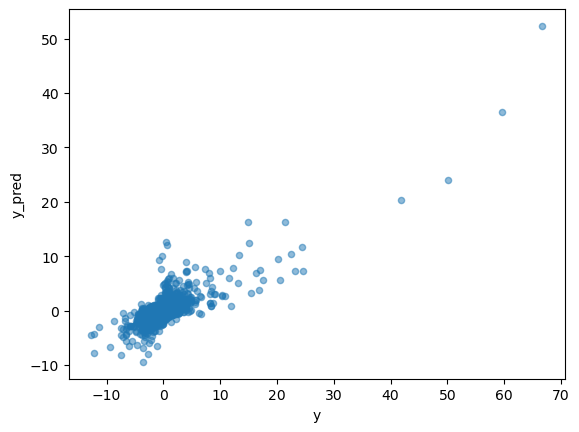

In [10]:
# Plot correlation between predicted and observed values
df_cmp = pd.DataFrame({
    'y': df_de.loc[("NK cells", "Prednisolone")].values.ravel(), 
    'y_pred': scm.predict([("NK cells", "Prednisolone")]).values.ravel()
})

# Make the plot square with same X and Y limits
df_cmp.plot.scatter(x='y', y='y_pred', alpha=0.5)

In [11]:
# Save model
scm.save("_models/config.pkl", "_models/weights.keras", "_models/result.pkl")

In [12]:
scm = scape.SCAPE.load("_models/config.pkl", "_models/weights.keras", "_models/result.pkl")
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 [==============================] - 1s 1s/step


A1BG  A1BG-AS1       A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                         
NK cells  Bosutinib   0.383608  0.150397 -0.118714   0.034104  0.312344   
          Belinostat  2.287691  3.217299 -8.687969 -17.341049 -3.499161   

                        A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                       ...   
NK cells  Bosutinib   0.802649  0.190315  0.205352 -0.011231  0.389813  ...   
          Belinostat  8.573669  1.835860  1.410513  5.420227  6.377146  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib  -0.058079 -0.209129  0.107847  0.131434  0.018571   
          Belinostat  6.394788  2.371404 -2.432016  0.728584 -1.770046   

                          ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
cell_type sm_name                                                       
NK cells  Bosutinib   0.125154  0.306387  0.120551  0.070030  0.120873  
          Belinostat  0.629093 -0.760563  5.597802 -1.075169 -2.961961  

[2 rows x 18211 columns]

## Save during training

In [13]:
scm = scape.SCAPE(model_setup)

result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=30,
    baselines=["zero", "slogpval_drug"],
    output_folder="_models",
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']
Model will be saved to _models\model.keras
Epoch    1: val_loss None -> 1.4176, train loss: 1.3070 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0068, 0.68%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7956, -25.70%
Epoch    2: val_loss 1.4176 -> 1.3814, train loss: 1.2787 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0332, 3.21%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8164, -22.49%
Epoch    3: val_loss 1.3814 -> 1.3550, train loss: 1.2506 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0534, 5.07%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8323, -20.15%
